In [1]:
from __future__ import division

import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
#import matplotlib.pyplot as plt
import scipy.misc
import os
import scipy.stats as ss
import math
#matplotlib inline

In [2]:
class Qnetwork():
    def __init__(self,h_size,action_num):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,3600,2],dtype=tf.float32)
        self.legal_actions =  tf.placeholder(shape=[None,action_num],dtype=tf.float32)
        
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,60,60,2])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[4,4],stride=[2,2],padding='VALID', activation_fn=self.relu, biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[2,2],stride=[1,1],padding='VALID', activation_fn=self.relu, biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=128,kernel_size=[2,2],stride=[1,1],padding='VALID', activation_fn=self.relu, biases_initializer=None)
#         self.conv4 = slim.conv2d( \
#             inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
#         print "CONV3",self.conv3
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
#         self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.stream = slim.flatten(self.conv3)
        self.stream0 = slim.fully_connected(self.stream, 128, activation_fn=self.relu)
    
        self.streamA = self.stream0
        self.streamV = self.stream0
        
        
#         self.streamV = slim.flatten(self.streamVC)
        
        self.streamA0 = slim.fully_connected(self.streamA,h_size, activation_fn=self.relu)
        self.streamV0 = slim.fully_connected(self.streamV, h_size, activation_fn=self.relu)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        action_num = np.int32(action_num)
        self.AW = tf.Variable(xavier_init([h_size,action_num]))
        self.VW = tf.Variable(xavier_init([h_size,1]))
        self.Advantage = tf.matmul(self.streamA0,self.AW)
        self.Value = tf.matmul(self.streamV0,self.VW)
        
#         self.Qout0 = self.Advantage
        #Then combine them together to get our final Q-values.
        self.Qout0 = self.Value  + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        action_num = np.int32(action_num)
#         self.legal_actions = np.int32(self.legal_actions)
#         print "Legal:", self.legal_actions, self.Qout
        self.Qout = tf.add(self.Qout0, self.legal_actions)
    #check
#         self.Qout = tf.multiply(self.Qout, tf.one_hot(self.legal_actions,action_num,dtype=tf.float32))
#         print "ONe:", tf.one_hot(self.legal_actions,action_num,dtype=tf.float32)
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,action_num,dtype=tf.float32)
# check
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
#         self.Q = tf.reduce_sum(self.Qout, axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
    def relu(self, x, alpha=0.01, max_value=None):
        '''ReLU.

        alpha: slope of negative section.
        '''
        negative_part = tf.nn.relu(-x)
        x = tf.nn.relu(x)
        if max_value is not None:
            x = tf.clip_by_value(x, tf.cast(0., dtype=tf.float32),
                                 tf.cast(max_value, dtype=tf.float32))
        x -= tf.constant(alpha, dtype=tf.float32) * negative_part
        return x

In [ ]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
        print "ADDED", len(self.buffer)
            
    def sample(self,size):
        print "BUFFer:", len(self.buffer)
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,6])

In [3]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [4]:
batch_size = 128 #How many experiences to use for each training step.
update_freq = 1 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.01 #Final chance of random action
anneling_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 1500#000 #How many episodes of game environment to train network with.
pre_train_steps = 2000#0000 #How many steps of random actions before training begins.
max_epLength = 500 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
action_num = 9 #total number of actions
path = "./dqn-3l-3600-nodbl" #The path to save our model to.
h_size = 64 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [5]:
import math
class priorized_experience_buffer():
    def __init__(self, buffer_size = 30000):
        self.buffer = []
        self.prob = []
        self.err = []
        self.buffer_size = buffer_size
        self.alpha = 0.2
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.err[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
            self.prob[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
        self.err.extend([10000]*len(experience))
        self.prob.extend([1]*len(experience))
#         print "ADDED", len(self.buffer)
            
    def updateErr(self, indx, error):
#         print indx
        for i in range(0, len(indx)):
            self.err[indx[i]] = math.sqrt(error[i])
        r_err = ss.rankdata(self.err)  #rank of the error from smallest (1) to largest
        self.prob = [1/(len(r_err)-i+1) for i in r_err]

        
    def priorized_sample(self,size):
        prb = [i**self.alpha for i in self.prob]
        t_s = [prb[0]]
        for i in range(1,len(self.prob)):
            t_s.append(prb[i]+t_s[i-1])
        batch = []
        mx_p = t_s[-1]
        
#         samp = np.random.uniform(0,mx_p,size)
        smp_set = set()
        
#         print "SAMP:", samp
#         print "TS:", t_s
        while len(smp_set)<batch_size:
            tmp = np.random.uniform(0,mx_p)
#             print tmp
            for j in range(0, len(t_s)):
                if t_s[j] > tmp:
                    smp_set.add(max(j-1,0))
                    break;
        for i in smp_set:
            batch.append([self.buffer[i], i])
        return np.array(batch)
#         return np.reshape(np.array(random.sample(self.buffer,size)),[size,6])

In [6]:
import os, sys
# if 'SUMO_HOME' in os.environ:

sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))

import traci
import traci.constants as tc

import numpy as np

import datetime

#Environment Model
sumoBinary = "/usr/local/bin/sumo"
sumoCmd = [sumoBinary, "-c", "./cross/cross.sumo.cfg"]
current_phases = [20,20,20,20]


def reset():
    traci.start(sumoCmd, label="sim1")
    tls = traci.trafficlights.getIDList()
    return tls
    
def state():
    for veh_id in traci.vehicle.getIDList():
        traci.vehicle.subscribe(veh_id, (tc.VAR_POSITION, tc.VAR_SPEED))
    p = traci.vehicle.getSubscriptionResults()
    p_state = np.zeros((60,60,2))
#     v_state = np.zeros((200,200))
    for x in p:
        ps = p[x][tc.VAR_POSITION]
        spd = p[x][tc.VAR_SPEED]
        p_state[int(ps[0]/5), int(ps[1]/5)] = [1, int(round(spd))]
#         v_state[int(ps[0]/5), int(ps[1]/5)] = spd
#     p_state[np.random.randint(0,2), np.random.randint(0,2)] = 1
#     v_state[np.random.randint(0,2), np.random.randint(0,2)] = 1
    p_state = np.reshape(p_state, [-1, 3600, 2])
    return p_state #, v_state]
    
def getLegalAction(phases):
    legal_action = np.zeros(9)-1
    i = 0
    for x in phases:
        if x>5:
            legal_action[i] = i
        if x<60:
            legal_action[i+5] = i+5
        i +=1
    legal_action[4] = 4
    return legal_action
    
def getPhaseFromAction(phases, act):
    if act<4:
        phases[int(act)] -= 5
    elif act>4:
        phases[int(act)-5] += 5
    return phases


def action(tls, ph, wait_time):  #parameters: the phase duration in the green signals
    tls_id = tls[0]
    init_p = traci.trafficlights.getPhase(tls_id) 
    prev = -1
    changed = False
    current_phases = ph
    p_state = np.zeros((60,60,2))
#     for x in ph:
#         if x<5 or x>60:
#             p_state = np.reshape(p_state, [-1, 3600, 2])
#             r = -99999
#             d = True
#             return p_state, r, d, 0
    step = 0
#     print "Start:", traci.simulation.getCurrentTime(), datetime.datetime.now().time()
    while traci.simulation.getMinExpectedNumber() > 0:
        c_p = traci.trafficlights.getPhase(tls_id)
        if c_p != prev and c_p%2==0:
            traci.trafficlights.setPhaseDuration(tls_id, ph[int(c_p/2)]-0.5)
            prev = c_p
        if init_p != c_p:
            changed = True
        if changed:
            if c_p == init_p:
                break
        traci.simulationStep()
        step += 1
        if step%10==0:
            for veh_id in traci.vehicle.getIDList():
#                 if traci.vehicle.getLaneID(veh_id)[1]=='o':
                wait_time_map[veh_id] = traci.vehicle.getAccumulatedWaitingTime(veh_id)
#     print "PASSS:", step
#     print "End:", traci.simulation.getCurrentTime(), datetime.datetime.now().time()
#     v_num = 0
    for veh_id in traci.vehicle.getIDList():
        traci.vehicle.subscribe(veh_id, (tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCUMULATED_WAITING_TIME))
#         v_num += 1
    p = traci.vehicle.getSubscriptionResults()
    
#     v_state = np.zeros((200,200))
    
    wait_temp = dict(wait_time_map)
    for x in p:
        ps = p[x][tc.VAR_POSITION]
        spd = p[x][tc.VAR_SPEED]
        p_state[int(ps[0]/5), int(ps[1]/5)] = [1, int(round(spd))]
#         wait_temp[x] = p[x][tc.VAR_ACCUMULATED_WAITING_TIME]
#         v_state[int(ps[0]/5), int(ps[1]/5)] = spd


#     wait_t = 0
#     v_n = 0
#     edge_list = ['1i', '2i', '3i', '4i']
#     for edge_id in edge_list:
#         wt = traci.edge.getWaitingTime(edge_id)
#         wait_t += wt
#         v_n += traci.edge.getLastStepVehicleNumber(edge_id)

    wait_t = sum(wait_temp[x] for x in wait_temp)
    
    d = False
    if traci.simulation.getMinExpectedNumber() == 0:
        d = True
    # average waiting time of every 'in-edge' vehicle
#     if v_n ==0:
#         wait_t = 0
#     else:
#         wait_t = wait_t/v_n
    r = wait_time-wait_t
#     wait_time = wait_t
#     p_state[np.random.randint(0,2), np.random.randint(0,2), np.random.randint(0,2)] = 1
#     p_state[np.random.randint(0,2), np.random.randint(0,2), np.random.randint(0,2)] = 1
    p_state = np.reshape(p_state, [-1, 3600, 2])
    return p_state,r,d,wait_t


def end():
    traci.close()
        

In [7]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size,np.int32(action_num))
targetQN = Qnetwork(h_size,np.int32(action_num))

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

# myBuffer = experience_buffer()
myBuffer0 = priorized_experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
wList = []
awList = []
tList = []
nList = []  #stops' percentage
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)
    
# env = ... #the sumo model 

init_phases = [20,20,20,20]


# env = Env(init_phases)

# env.reset()
# for i in range(1, 10000):
#     traci.simulationStep()
# env.end()


print "HELLO"
sess = tf.InteractiveSession()

# r = 0
# tf.summary.scalar('Reward', r)
tf.summary.scalar('Loss', mainQN.loss)

rfile = open(path+'/reward-rl.txt', 'w')
wfile = open(path+'/wait-rl.txt', 'w')
awfile = open(path+'/acumu-wait-rl.txt', 'w')
tfile = open(path+'/throput-rl.txt', 'w')


merged = tf.summary.merge_all()
s_writer = tf.summary.FileWriter(path+'/train', sess.graph)
s_writer.add_graph(sess.graph)
    
sess.run(init)
tf.global_variables_initializer().run()
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.

HELLO


In [9]:
# num_episodes = 2000
# total_steps = 1
# e = startE
# stepDrop = (startE - endE)/anneling_steps
for i in range(41,num_episodes):
#     episodeBuffer = experience_buffer()
    episodeBuffer0 = priorized_experience_buffer()
    #Reset environment and get first new observation
#         s = env.reset()
#         s = processState(s)
    tls = reset()
    current_phases = list(init_phases)
    s = state()#np.random.rand(1,10000)
    wait_time_map = {}
    wait_time = 0
    d = False
    rAll = 0
    j = 0
    #The Q-Network
    print "III:", i, e
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
#         print j
        #Choose an action by greedily (with e chance of random action) from the Q-network

        #read traffic light states
        legal_action = getLegalAction(current_phases) #np.random.randint(1,action_num,size=action_num) #[1,2,-1,4,5]
#         print legal_action
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a_cnd = [x for x in legal_action if x!=-1]
            a_num = len(a_cnd)
            a = np.random.randint(0, a_num)
            a = a_cnd[a]
#             print "YY", a
        else:
#             print "XX"
#             print legal_action
            np.reshape(s, [-1,3600,2])
            legal_a_one = [0 if x!=-1 else -99999 for x in legal_action]
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:s,mainQN.legal_actions:[legal_a_one]})[0]
#             a = a[0]
#             print 'Qot:', Qot, 'Qot0:', Qot0

#             s1,r,d = env.takeAction(a)  #s', reward, end(True/False)
#             s1 = processState(s1)
        
        ph = getPhaseFromAction(current_phases,a)        
        s1, r, d, wait_time = action(tls, ph, wait_time)
        current_phases = ph
#         if total_steps > pre_train_steps:
#        print  ph, "\n", i, j, "Reward----", r
#         summary = sess.run(merged)
#         s_writer.add_summary(summary, i)
#             s1 = np.random.rand(1,10000)
#             r = np.random.rand()
#             d = False
        total_steps += 1
        legal_a_one = [0 if x!=-1 else -99999 for x in legal_action]
        legal_act_s1 = getLegalAction(ph)
        legal_a_one_s1 = [0 if x!=-1 else -99999 for x in legal_act_s1]
        episodeBuffer0.add(np.reshape(np.array([s,a,r,s1,d,legal_a_one, legal_a_one_s1]),[1,7])) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps:
            if e > endE:
                e -= stepDrop
#             myBuffer0.add(episodeBuffer0.buffer) #remove later
            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer0.priorized_sample(batch_size) #Get a random batch of experiences.
                indx = np.reshape(np.vstack(trainBatch[:,1]), [batch_size])
                indx = indx.astype(int)
                trainBatch = np.vstack(trainBatch[:,0])
#                 print "SHAPE:", np.vstack(trainBatch[:,3]).shape
#                     ps_batch = [trainBatch[:,0][i][0] for i in range(0, batch_size)]
#                     spd_batch = [trainBatch[:,0][i][1] for i in range(0, batch_size)]

#                     print trainBatch[:, 3]
                #Below we perform the Double-DQN update to the target Q-values np.vstack(trainBatch[:,3][0])
                Q1 = sess.run( targetQN.predict,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3]),targetQN.legal_actions:np.vstack(trainBatch[:,5])}) 
#                 print 'Qot:', Qot, 'Qot0:', Qot0
            # input s'
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3]), targetQN.legal_actions:np.vstack(trainBatch[:,6])})
                # get targetQ at s'
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
#                 print targetQ
                #Update the network with our target values.
                summry, err, ls, md = sess.run([merged, mainQN.td_error, mainQN.loss, mainQN.updateModel],  \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1],mainQN.legal_actions:np.vstack(trainBatch[:,5])})

                s_writer.add_summary(summry, total_steps)
#                 print "ERROR:",err
#                 print "loss:", ls
                updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.

                myBuffer0.updateErr(indx, err)
#                     break
        rAll += r
        s = s1

        if d == True:
#             end()
            break
    end()    

    myBuffer0.add(episodeBuffer0.buffer)
#         print len(myBuffer.buffer), "MY Buffer:",myBuffer.buffer
    jList.append(j)
    rList.append(rAll)
    rfile.write(str(rAll)+'\n')
    wt = sum(wait_time_map[x] for x in wait_time_map)
    wtAve = wt/len(wait_time_map)
    wList.append(wtAve)
    wfile.write(str(wtAve)+'\n')
    awList.append(wt)
    awfile.write(str(wt)+'\n')
    tList.append(len(wait_time_map))
    tfile.write(str(len(wait_time_map))+'\n')
    tmp = [x for x in wait_time_map if wait_time_map[x] > 1]
    nList.append(len(tmp)/len(wait_time_map))
    print "Total Reward---------------",  rAll
    #Periodically save the model. 
    if i % 100 == 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
#         if len(rList) % 10 == 0:
#             print(total_steps,np.mean(rList[-10:]), e)
saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Could not connect to TraCI server at localhost:60655 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 41 0.999901
Total Reward--------------- -71209.5
Could not connect to TraCI server at localhost:49813 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 42 0.995248
Total Reward--------------- -57580.5
Could not connect to TraCI server at localhost:55893 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 43 0.989605
Total Reward--------------- -64634.0
Could not connect to TraCI server at localhost:52444 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 44 0.98218
Total Reward--------------- -66350.5
Could not connect to TraCI server at localhost:43172 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 45 0.977329
Total Reward--------------- -40213.5
Could not connect to TraCI server at localhost:52206 [Errno 111] Connection refused
 Retrying in 1 seconds
III: 46 0.971389
Total Reward--------------- -65216.5
Could not connect to TraCI server a

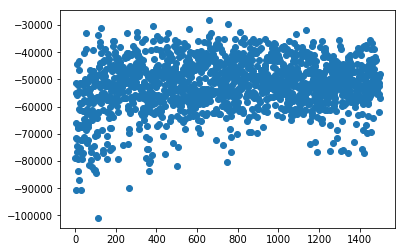

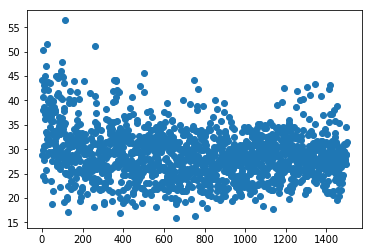

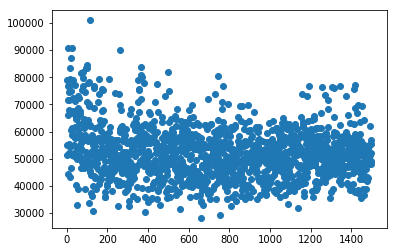

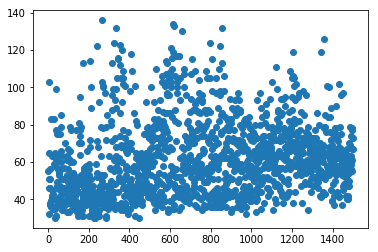

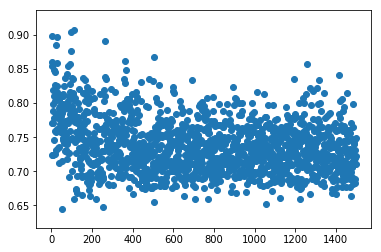

In [10]:
#for w in wait_time_map:
#    print w, ":", wait_time_map[w]
rfile = open(path+'/reward-rl.txt', 'w')
wfile = open(path+'/wait-rl.txt', 'w')
awfile = open(path+'/acc-wait-rl.txt', 'w')
tfile = open(path+'/throput-rl.txt', 'w')
jfile = open(path+'/epi-len-rl.txt', 'w')
nfile = open(path+'/stop-rl.txt', 'w')

for x in rList:
    rfile.write(str(x)+'\n')
for x in wList:
    wfile.write(str(x)+'\n')
for x in awList:
    awfile.write(str(x)+'\n')
for x in tList:
    tfile.write(str(x)+'\n')
for x in jList:
    jfile.write(str(x)+'\n')
for x in nList:
    nfile.write(str(x)+'\n')
   
import matplotlib.pyplot as plt
x =range(1, len(rList)+1)

plt.scatter(x, rList)
plt.show()
plt.savefig(path+"/reward.eps", format="eps")

plt.scatter(x, wList)
plt.show()
plt.savefig(path+"/wait.eps", format="eps")

plt.scatter(x, awList)
plt.show()
plt.savefig(path+"/acc-wait.eps", format="eps")

plt.scatter(x, jList)
plt.show()
plt.savefig(path+"/epi-len.eps", format="eps")

plt.scatter(x, nList)
plt.show()
# print rList
# print wList
# print awList
# print tList
# print jList

In [ ]:
x=max(wait_time_map, key=lambda x:wait_time_map[x])
print wait_time_map[x]
tmp = [x for x in wait_time_map if wait_time_map[x] > 0]
print len(tmp), len(wait_time_map)
print len(tmp)/len(wait_time_map)

In [ ]:
print len(myBuffer0.buffer)
print myBuffer0.prob
prb = [i**myBuffer0.alpha for i in myBuffer0.prob]
t_s = [prb[0]]
for i in range(1,len(myBuffer0.prob)):
    t_s.append(prb[i]+t_s[i-1])
print t_s
batch_size = 64
smp_set = set()
# t_s = [0,1,2,3,4,5,6,7,8,9]
mx_p = max(t_s)
print "TS:",t_s[-1]
while len(smp_set)<batch_size:
    tmp = np.random.uniform(0,mx_p)
    print tmp
    for j in range(0, len(t_s)):
        if t_s[j] > tmp:
            smp_set.add(max(j-1,0))
            break;
print "Done"

In [ ]:
legal_a_one[2] = 99999
mainQN1 = Qnetwork(h_size,np.int32(action_num))
sess.run(init)
a = sess.run(mainQN1.predict,feed_dict={mainQN1.scalarInput:s,mainQN1.legal_actions:[legal_a_one]})
print a
print legal_a_one

In [ ]:
summary = sess.run(merged)
s_writer.add_summary(summary, i)

In [ ]:
trainBatch = myBuffer0.priorized_sample(batch_size)
# print trainBatch[:,0]
t = np.vstack(trainBatch[:,1])
print t[0], t[1]
print t.shape
p = np.vstack(t[:,0])
print p.shape
print "SS:", np.vstack(trainBatch[:,0]).shape
# trainBatch = trainBatch[:, 0]
print trainBatch.shape
print "SHAPE:", np.vstack(trainBatch[:,3]).shape
print trainBatch[:,3].shape
x= np.vstack(trainBatch[:,3])
x1 = np.reshape(x, (2,200,200,2))
print x1.shape#, x1[1]
print np.vstack(x1).shape
print "S:",s.shape

In [ ]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size,np.int32(action_num))
targetQN = Qnetwork(h_size,np.int32(action_num))

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)
    
# env = ... #the sumo model 

print "HELLO"
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
#         s = env.reset()
#         s = processState(s)
        s = np.random.rand(1,10000)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        print "III:"
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            print j
            #Choose an action by greedily (with e chance of random action) from the Q-network
            
            #read traffic light states
            legal_action = np.random.randint(1,action_num,size=action_num) #[1,2,-1,4,5]
            print legal_action
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a_cnd = [x for x in legal_action if x!=-1]
                a_num = len(a_cnd)
                a = np.random.randint(0, a_num)
                print a 
                a = a_cnd[a]
                print "YY"
            else:
                print "XX"
                print legal_action
                np.reshape(s, [1,10000])
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:s,mainQN.legal_actions:[legal_action]})[0]
            
#             s1,r,d = env.takeAction(a)  #s', reward, end(True/False)
#             s1 = processState(s1)
            s1 = np.random.rand(1,10000)
            r = np.random.rand()
#             d = False
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d,legal_action]),[1,6])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    print "Training:",trainBatch[:,5]
#                     print trainBatch[:, 3]
                    print np.vstack(trainBatch[:,5])
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3]),mainQN.legal_actions:np.vstack(trainBatch[:,5])}) 
                    # input s'
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    # get targetQ at s'
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:
                break
        
        myBuffer.add(episodeBuffer.buffer)
        print len(myBuffer.buffer), "MY Buffer:",myBuffer.buffer
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")